# NER Analysis on Agriculture Data

Using CamemBERT-based French NER model to extract named entities from agriculture-related media coverage.

**Important**: The transcriptions are all lowercase, so we use `Jean-Baptiste/camembert-ner` which is robust to non-capitalized text.

**Entity types:**
- PER: Person names
- LOC: Location names
- ORG: Organization names
- MISC: Other names

In [3]:
import sys
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Transformers imports for CamemBERT NER
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

print("Imports successful!")

/Users/quentin/miniconda3/envs/dataforgood/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful!


In [4]:
# Check PyTorch and device availability
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Metal Performance Shaders) available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# Determine the best device to use
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"✅ Using M4 GPU with MPS: {device}")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA GPU: {device}")
else:
    device = torch.device("cpu")
    print(f"⚠️  Using CPU: {device}")

print(f"Selected device: {device}")

PyTorch version: 2.10.0
MPS (Metal Performance Shaders) available: True
MPS built: True
✅ Using M4 GPU with MPS: mps
Selected device: mps


## 1. Load Agriculture Data (Train + Test)

In [5]:
from main.main import get_agriculture_data

# Load agriculture data for both splits
df_train = get_agriculture_data(split="train")
df_test = get_agriculture_data(split="test")

print(f"\nTrain shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Total: {len(df_train) + len(df_test)} documents")

Loading cached train data from /Users/quentin/Documents/Hackathon/DataForGood/ome-hackathon-season-14/data/train_cached.parquet
Filtered 2565 agriculture_alimentation records from 8349 total records
Loading cached test data from /Users/quentin/Documents/Hackathon/DataForGood/ome-hackathon-season-14/data/test_cached.parquet
Filtered 308 agriculture_alimentation records from 1000 total records

Train shape: (2565, 14)
Test shape: (308, 14)
Total: 2873 documents


## 1.5. Text Deduplication Preprocessing

Remove repetitive text loops before NER processing to improve quality and efficiency.

In [6]:
# Import deduplication utilities
from deduplication import preprocess_dataframe, get_deduplication_stats

print("📊 Analyzing text repetition patterns...")

# Get stats before deduplication
stats_train = get_deduplication_stats(df_train)
stats_test = get_deduplication_stats(df_test)

print(f"\nBEFORE DEDUPLICATION:")
print(f"Train - Records: {stats_train['total_records']:,}, Records with loops: {stats_train['records_with_loops']:,}")
print(f"      - Total chars: {stats_train['original_total_chars']:,}")
print(f"Test  - Records: {stats_test['total_records']:,}, Records with loops: {stats_test['records_with_loops']:,}")
print(f"      - Total chars: {stats_test['original_total_chars']:,}")

print("\n🔧 Applying deduplication preprocessing...")

# Apply deduplication to both datasets
df_train_clean = preprocess_dataframe(df_train, text_column="report_text", verify=True)
df_test_clean = preprocess_dataframe(df_test, text_column="report_text", verify=True)

# Get stats after deduplication
stats_train_after = get_deduplication_stats(df_train_clean)
stats_test_after = get_deduplication_stats(df_test_clean)

print(f"\nAFTER DEDUPLICATION:")
print(f"Train - Compression ratio: {stats_train['compression_ratio']:.1f}x")
print(f"      - Chars: {stats_train['original_total_chars']:,} → {stats_train_after['deduplicated_total_chars']:,}")
print(f"Test  - Compression ratio: {stats_test['compression_ratio']:.1f}x") 
print(f"      - Chars: {stats_test['original_total_chars']:,} → {stats_test_after['deduplicated_total_chars']:,}")

print("✅ Deduplication complete!")

# Update the dataframes for subsequent processing
df_train = df_train_clean
df_test = df_test_clean

📊 Analyzing text repetition patterns...

BEFORE DEDUPLICATION:
Train - Records: 2,565, Records with loops: 2,484
      - Total chars: 83,158,047
Test  - Records: 308, Records with loops: 298
      - Total chars: 9,322,109

🔧 Applying deduplication preprocessing...

AFTER DEDUPLICATION:
Train - Compression ratio: 11.1x
      - Chars: 83,158,047 → 7,499,270
Test  - Compression ratio: 9.4x
      - Chars: 9,322,109 → 987,310
✅ Deduplication complete!


## 2. Load CamemBERT NER Model

In [7]:
print("Loading CamemBERT NER model...")
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

# Move model to the selected device (MPS for M4 GPU)
model = model.to(device)
print(f"Model moved to device: {device}")

ner_pipeline = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)
print("Model loaded successfully with GPU acceleration!")

Loading CamemBERT NER model...


Device set to use mps


Model moved to device: mps
Model loaded successfully with GPU acceleration!


## 3. NER Extraction Function

In [8]:
def extract_entities_from_text(text, ner_pipeline, max_chars=2000):
    """
    Extract named entities from a long text by chunking.
    Returns dict with list of entities for each type.
    """
    entities = {'PER': [], 'LOC': [], 'ORG': [], 'MISC': []}
    
    # Split text into chunks
    for i in range(0, len(text), max_chars):
        chunk = text[i:i+max_chars]
        if i + max_chars < len(text):
            last_space = chunk.rfind(' ')
            if last_space > 0:
                chunk = chunk[:last_space]
        
        try:
            results = ner_pipeline(chunk)
            for r in results:
                entity_type = r['entity_group']
                if entity_type in entities:
                    entity_text = r['word'].strip().lower()
                    if len(entity_text) > 1:
                        entities[entity_type].append(entity_text)
        except:
            continue
    
    return entities

print("Entity extraction function defined.")

Entity extraction function defined.


## 4. Process Full Dataset

In [9]:
def process_dataframe(df, ner_pipeline, desc="Processing"):
    """
    Process a dataframe and add NER columns.
    Returns dataframe with 4 new columns: ner_PER, ner_LOC, ner_ORG, ner_MISC
    """
    df = df.copy()
    
    # Initialize columns
    ner_results = {'ner_PER': [], 'ner_LOC': [], 'ner_ORG': [], 'ner_MISC': []}
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        text = row['report_text']
        entities = extract_entities_from_text(text, ner_pipeline)
        
        # Store as JSON strings for easy saving/loading
        ner_results['ner_PER'].append(json.dumps(entities['PER'], ensure_ascii=False))
        ner_results['ner_LOC'].append(json.dumps(entities['LOC'], ensure_ascii=False))
        ner_results['ner_ORG'].append(json.dumps(entities['ORG'], ensure_ascii=False))
        ner_results['ner_MISC'].append(json.dumps(entities['MISC'], ensure_ascii=False))
    
    # Add columns to dataframe
    for col, values in ner_results.items():
        df[col] = values
    
    return df

print("Processing function defined.")

Processing function defined.


In [10]:
# Process TRAIN set
print(f"Processing {len(df_train)} train documents...")
df_train_ner = process_dataframe(df_train, ner_pipeline, desc="Train")
print(f"\nTrain processing complete! Shape: {df_train_ner.shape}")

Processing 2565 train documents...


Train: 100%|██████████| 2565/2565 [02:29<00:00, 17.16it/s]


Train processing complete! Shape: (2565, 18)


In [11]:
# Process TEST set
print(f"Processing {len(df_test)} test documents...")
df_test_ner = process_dataframe(df_test, ner_pipeline, desc="Test")
print(f"\nTest processing complete! Shape: {df_test_ner.shape}")

Processing 308 test documents...


Test: 100%|██████████| 308/308 [00:18<00:00, 16.74it/s]


Test processing complete! Shape: (308, 18)


## 5. Save Processed DataFrames

In [12]:
# Save to data folder
data_dir = Path.cwd().parent / "data"
data_dir.mkdir(exist_ok=True)

train_path = data_dir / "agriculture_train_ner.parquet"
test_path = data_dir / "agriculture_test_ner.parquet"

df_train_ner.to_parquet(train_path, index=False)
df_test_ner.to_parquet(test_path, index=False)

print(f"Saved train data to: {train_path}")
print(f"Saved test data to: {test_path}")
print(f"\nNew columns: {[c for c in df_train_ner.columns if c.startswith('ner_')]}")

Saved train data to: /Users/quentin/Documents/Hackathon/DataForGood/ome-hackathon-season-14/data/agriculture_train_ner.parquet
Saved test data to: /Users/quentin/Documents/Hackathon/DataForGood/ome-hackathon-season-14/data/agriculture_test_ner.parquet

New columns: ['ner_PER', 'ner_LOC', 'ner_ORG', 'ner_MISC']


In [16]:
df_train_ner.head()

,channel_title,channel_name,country,segment_id,segment_start,segment_end,duration_seconds,num_keywords,avg_density,themes,report_text,category,secondary_categories,text_type,ner_PER,ner_LOC,ner_ORG,ner_MISC
2,France 2,france2,france,5788,2025-12-03 06:34:04.031 +0100,2025-12-03 06:36:02.025 +0100,118,18,13.4,", attenuation_climatique_solutions_indirectes,...",plus vendu au monde a la une également cette c...,agriculture_alimentation,[energy],segment,"[""mathieu riou""]","[""doubs"", ""france""]","[""sécurité sociale""]","[""écran noir"", ""budget du de budget la"", ""covid""]"
3,M6,m6,france,3445,2025-11-17 15:20:24.048 +0100,2025-11-17 15:21:26.064 +0100,62,4,5.3,", biodiversite_causes_indirectes, changement_c...",christo popov thomas fersen ces enseignants et...,agriculture_alimentation,[],segment,"[""christo popov thomas fersen"", ""valentin le i...","[""paris""]",[],"[""graphique""]"
9,M6,m6,france,1379,2025-05-13 20:14:11.059 +0200,2025-05-13 20:15:50.004 +0200,99,8,8.1,"attenuation_climatique_solutions_indirectes, b...",la baignade tourne court sera <unk> occasion d...,agriculture_alimentation,[],segment,"[""lionel<unk> basile"", ""lionel"", ""mber ota""]","[""porquerolles"", ""caraïbes"", ""tréteaux"", ""parc...",[],"[""festival de cannes""]"
14,TF1,tf1,france,4852,2025-12-25 09:11:59.056 +0100,2025-12-25 09:13:11.082 +0100,72,15,17.2,"adaptation_climatique_solutions, attenuation_c...",le jardin ce ne sont pas uniquement des matièr...,agriculture_alimentation,[],segment,"[""pierre le cultivateur"", ""pierre le cultivate...",[],[],"[""avez"", ""pierre"", ""votre dans jardin votre ja..."
17,France 2,france2,france,5744,2025-11-30 07:36:06.090 +0100,2025-11-30 07:38:37.058 +0100,151,11,10.5,"biodiversite_causes, biodiversite_concepts_gen...",aux etats-unis que pensez-vous d' aller faire ...,agriculture_alimentation,[],segment,"[""sébastien thomas"", ""tramier"", ""tramier"", ""sé...","[""etats-unis"", ""illinois"", ""cana"", ""brive"", ""c...",[],"[""noël""]"


## 6. Quick Analysis

In [13]:
# Aggregate all entities across the dataset
def aggregate_entities(df):
    all_entities = {'PER': [], 'LOC': [], 'ORG': [], 'MISC': []}
    
    for col, entity_type in [('ner_PER', 'PER'), ('ner_LOC', 'LOC'), ('ner_ORG', 'ORG'), ('ner_MISC', 'MISC')]:
        for entities_json in df[col]:
            entities = json.loads(entities_json)
            all_entities[entity_type].extend(entities)
    
    return all_entities

# Combine train and test
all_entities = aggregate_entities(pd.concat([df_train_ner, df_test_ner]))

print("="*70)
print("TOP ENTITIES IN AGRICULTURE COVERAGE (FULL DATASET)")
print("="*70)

for entity_type in ['PER', 'ORG', 'LOC', 'MISC']:
    counter = Counter(all_entities[entity_type])
    print(f"\n--- {entity_type} ({len(counter)} unique) ---")
    for entity, count in counter.most_common(20):
        print(f"  {entity}: {count}")

TOP ENTITIES IN AGRICULTURE COVERAGE (FULL DATASET)

--- PER (5520 unique) ---
  donald trump: 225
  emmanuel macron: 117
  julien: 63
  rémi camus: 62
  trump: 59
  duplomb: 54
  david: 54
  sébastien: 43
  françois bayrou: 41
  vladimir poutine: 38
  macron: 36
  volodymyr zelensky: 36
  julia: 35
  nicolas: 34
  mathieu: 33
  karim: 33
  marie: 32
  bruce toussaint: 31
  vincent: 30
  ange noiret: 30

--- ORG (1946 unique) ---
  union européenne: 100
  tf1: 96
  mercosur: 90
  assemblée: 80
  france deux: 76
  france trois: 76
  assemblée nationale: 68
  leclerc: 61
  m6: 60
  nestlé: 57
  france tv: 50
  fnsea: 44
  psg: 42
  europe: 41
  office français de la biodiversité: 40
  perrier: 40
  auchan: 39
  etat: 38
  lci: 31
  veolia: 30

--- LOC (3837 unique) ---
  france: 1537
  la france: 566
  paris: 489
  europe: 312
  etats-unis: 274
  français: 268
  bretagne: 226
  méditerranée: 174
  camargue: 156
  ukraine: 122
  espagne: 121
  marseille: 108
  bordeaux: 108
  île-de-franc

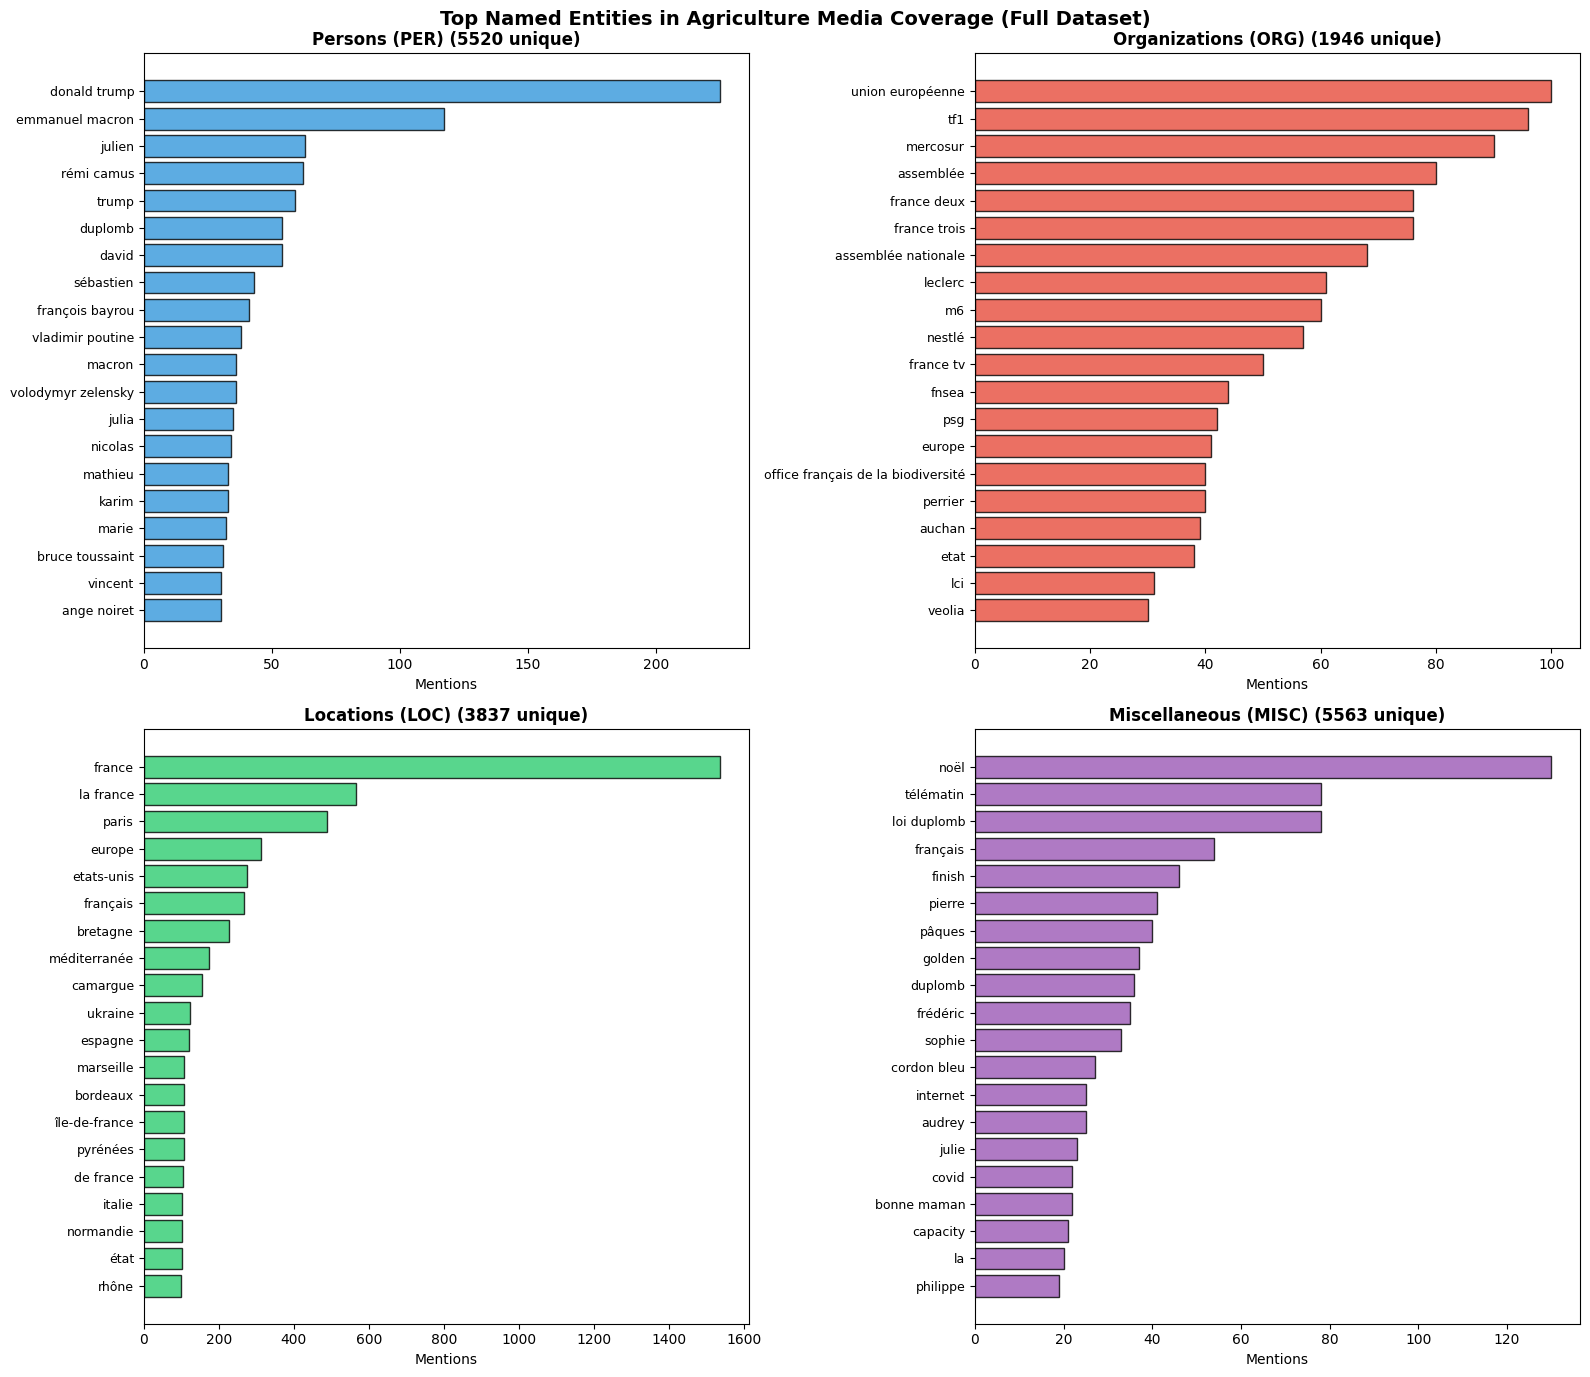

In [14]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

entity_types = ['PER', 'ORG', 'LOC', 'MISC']
titles = ['Persons (PER)', 'Organizations (ORG)', 'Locations (LOC)', 'Miscellaneous (MISC)']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

for ax, entity_type, title, color in zip(axes.flat, entity_types, titles, colors):
    counter = Counter(all_entities[entity_type])
    top = counter.most_common(20)
    if top:
        entities, counts = zip(*top)
        y_pos = range(len(entities))
        ax.barh(y_pos, counts, color=color, edgecolor='black', alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(entities, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Mentions')
        ax.set_title(f"{title} ({len(counter)} unique)", fontsize=12, fontweight='bold')

plt.suptitle('Top Named Entities in Agriculture Media Coverage (Full Dataset)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(data_dir / 'ner_agriculture_viz.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Summary
print("="*70)
print("SUMMARY")
print("="*70)
print(f"Documents processed: {len(df_train_ner) + len(df_test_ner)}")
print(f"  - Train: {len(df_train_ner)}")
print(f"  - Test: {len(df_test_ner)}")
print(f"\nTotal entities extracted: {sum(len(v) for v in all_entities.values())}")
for entity_type, entities in all_entities.items():
    print(f"  - {entity_type}: {len(entities)} mentions, {len(set(entities))} unique")
print(f"\nFiles saved:")
print(f"  - {train_path}")
print(f"  - {test_path}")

SUMMARY
Documents processed: 2873
  - Train: 2565
  - Test: 308

Total entities extracted: 44342
  - PER: 11695 mentions, 5520 unique
  - LOC: 18364 mentions, 3837 unique
  - ORG: 5279 mentions, 1946 unique
  - MISC: 9004 mentions, 5563 unique

Files saved:
  - /Users/quentin/Documents/Hackathon/DataForGood/ome-hackathon-season-14/data/agriculture_train_ner.parquet
  - /Users/quentin/Documents/Hackathon/DataForGood/ome-hackathon-season-14/data/agriculture_test_ner.parquet
